In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import time
from sklearn.utils.extmath import randomized_svd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [2]:
def loadBradyHShdf5(file,normalize='yes'):
    '''

    Parameters
    ----------
    file : str
        path to brady hotspring h5py data file
    normalize : str, optional
        "yes" or "no". Indicates whether or not to remove laser drift and 
        normalize. The default is 'yes'.

    Returns
    -------
    data : np array
        channel by samples numpy array of data
    timestamp_arr : numpy array
        array of the timestamps corresponding to the various samples in the 
        data. Timestamps for brady hotspring data are with respect to the 
        beginning time of the survey.

    '''
    
    with h5py.File(file,'r') as open_file: 
        dataset = open_file['das']
        time=open_file['t']
        data=np.array(dataset)
        timestamp_arr=np.array(time)
    data = np.transpose(data)
    if normalize=='yes':
        nSamples=np.shape(data)[1]
        # get rid of laser drift
        med = np.median(data,axis=0)
        for i in range(nSamples):
          data[:,i] = data[:,i] - med[i]
          
        max_of_rows = abs(data[:,:]).sum(axis=1)
        data = data/ max_of_rows[:, np.newaxis]
    return data, timestamp_arr

def windowed_spectra(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):
    """
    Calculate the frequency domain representation of data in windows.
    """

    win_start = 0
    window_samples = int(subwindow_len / sample_interval)
    total_samples = data.shape[-1]
    overlap = int(overlap/sample_interval)
    intervals = np.arange(window_samples, total_samples+1, window_samples, dtype=int) # break time series into windowed intervals

    win_end = intervals[0]

    absolute_spectra = np.fft.rfft(data[:,win_start:win_end])
    win_spectra = absolute_spectra[np.newaxis]

    while win_end < total_samples:
        win_start = win_end - overlap
        win_end = win_start + window_samples
        absolute_spectra = np.fft.rfft(data[:,win_start:win_end])
        win_spectra = np.append(
            win_spectra, absolute_spectra[np.newaxis], axis=0
        )
        # win_start = win_end
        
    
    frequencies = np.fft.rfftfreq(window_samples, sample_interval)

    return win_spectra, frequencies

def normalised_windowed_spectra(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):

    win_spectra, frequencies = windowed_spectra(data, subwindow_len,overlap,freq,sample_interval)
    
    # win_spectra = np.absolute(win_spectra)**2 # sub for next line
    # win_spectra = win_spectra * np.conjugate(win_spectra) # absolutes square of spectra. We need this if
    # we want to use the normalised spectra to calculate welch coherence.
    # normalizer = np.sum(win_spectra, axis=0)

    normalizer = np.sum(np.absolute(win_spectra)**2, axis=0)
    normalizer = np.tile(np.sqrt(normalizer),(win_spectra.shape[0],1,1))
    normalizer = normalizer.transpose(2,1,0)

    normalized_spectra = win_spectra.transpose(2,1,0) / normalizer

    return normalized_spectra, frequencies

def welch_coherence(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):
    """
    Calculate the coherence matrix at all (or particular frequencies: yet to be implemented)
    using the welch method.
    """

    win_spectra, frequencies = windowed_spectra(data, subwindow_len,overlap,freq,sample_interval)

    normalizer = np.sum(np.absolute(win_spectra)**2, axis=0)
    normalizer = np.tile(normalizer,(normalizer.shape[0],1,1))
    normalizer = normalizer * normalizer.transpose((1,0,2))
    normalizer = normalizer.transpose(2,1,0)

    welch_numerator = np.matmul(win_spectra.transpose(2,1,0), np.conjugate(win_spectra.transpose(2,0,1)))
    welch_numerator = np.absolute(welch_numerator)**2
    coherence = np.multiply(welch_numerator,1/normalizer)

    return coherence, frequencies



In [3]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083818.h5"
data3,_ = loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data,_ = loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2,_= loadBradyHShdf5(file,normalize='no')

# signalToUse=np.append(data[:,24976:],data2[:,:10000],axis=1)
data = np.append(data,data2,axis=1)
data = np.append(data,data3,axis=1)
samples_per_sec=1000

In [4]:
start_ch = 1000
nchannels = 3000
# start_ch = 4500
# nchannels = 1000
nsensors = 200
norm_win_spectra, frequencies = normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/nsensors)], 5, 2.5, sample_interval=0.001)

# welch_coherence = np.matmul(norm_win_spectra.transpose(2,1,0), np.conjugate(norm_win_spectra.transpose(2,0,1)))
welch_coherence_mat = np.matmul(norm_win_spectra, np.conjugate(norm_win_spectra.transpose(0,2,1)))
# welch_coherence_mat = np.absolute(welch_coherence_mat)**2

In [5]:
RandA = norm_win_spectra[300,:,:]
nreps = 10

approx_rank = int(len(RandA)/2)

t0 = time.time()
for i in range(nreps):
    Q,R = np.linalg.qr(RandA)
    # qr_approx2 = np.sum(np.absolute(R@R.transpose()), axis=0)**2
    qr_approx = np.diag(np.absolute(R@R.transpose()))**2

    Q2,R2 = np.linalg.qr(RandA.T)
    qr_approx2 = np.diag(np.absolute(R2@R2.transpose()))**2
t1 = time.time()
qr_time = t1-t0

print("QR time: ", qr_time)

t0 = time.time()
for i in range(nreps):
    U, S, Vh = np.linalg.svd(RandA)
    svd_approx = S**4
t1 = time.time()
svd_time = t1-t0

print("SVD time: ", svd_time)

t0 = time.time()
for i in range(nreps):
    coherence_mat = np.absolute(RandA@np.conjugate(RandA.transpose()))**2
    eigenvals, _ = np.linalg.eig(coherence_mat)
t1 = time.time()
eig_time = t1-t0

print("Eigenvalue time: ", svd_time)

t0 = time.time()
for i in range(nreps):
    rU, rS, rVh = randomized_svd(RandA, approx_rank)
    rsvd_approx = rS**4
t1 = time.time()
rsvd_time = t1-t0

print("Randomized SVD time: ", rsvd_time)

QR time:  0.3199961185455322
SVD time:  0.67201828956604
Eigenvalue time:  0.67201828956604
Randomized SVD time:  0.8240008354187012


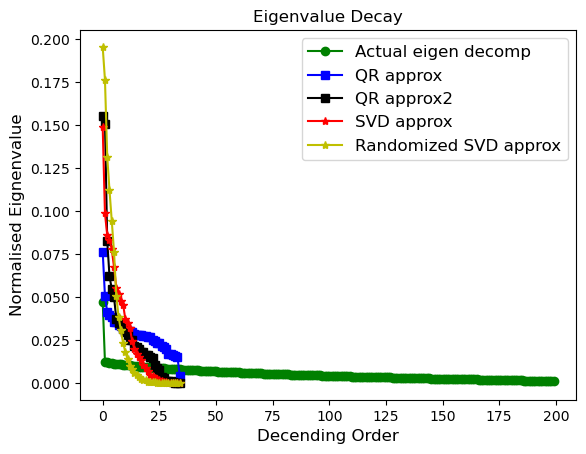

In [6]:
fsize = 12
qr_approx = np.sort(qr_approx)[::-1]
qr_approx2 = np.sort(qr_approx2)[::-1]
# qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
qr_approx = qr_approx/np.sum(np.absolute(qr_approx))
qr_approx2 = qr_approx2/np.sum(np.absolute(qr_approx2))

actual_eigenval = np.sort(eigenvals)[::-1]
actual_eigenval = actual_eigenval/np.sum(actual_eigenval)

svd_approx = svd_approx/np.sum(svd_approx)

rsvd_approx = rsvd_approx/np.sum(rsvd_approx)

plt.plot(actual_eigenval[:6*len(qr_approx)], "g-o", label="Actual eigen decomp")
plt.plot(qr_approx, "b-s", label="QR approx")
plt.plot(qr_approx2, "k-s", label="QR approx2")
plt.plot(svd_approx, "r-*", label="SVD approx")
plt.plot(rsvd_approx, "y-*", label="Randomized SVD approx")

plt.xlabel('Decending Order',fontsize=fsize)
plt.ylabel('Normalised Eignenvalue',fontsize=fsize)
plt.title('Eigenvalue Decay',fontsize=fsize)
# plt.yscale('log')
plt.legend(fontsize=fsize)

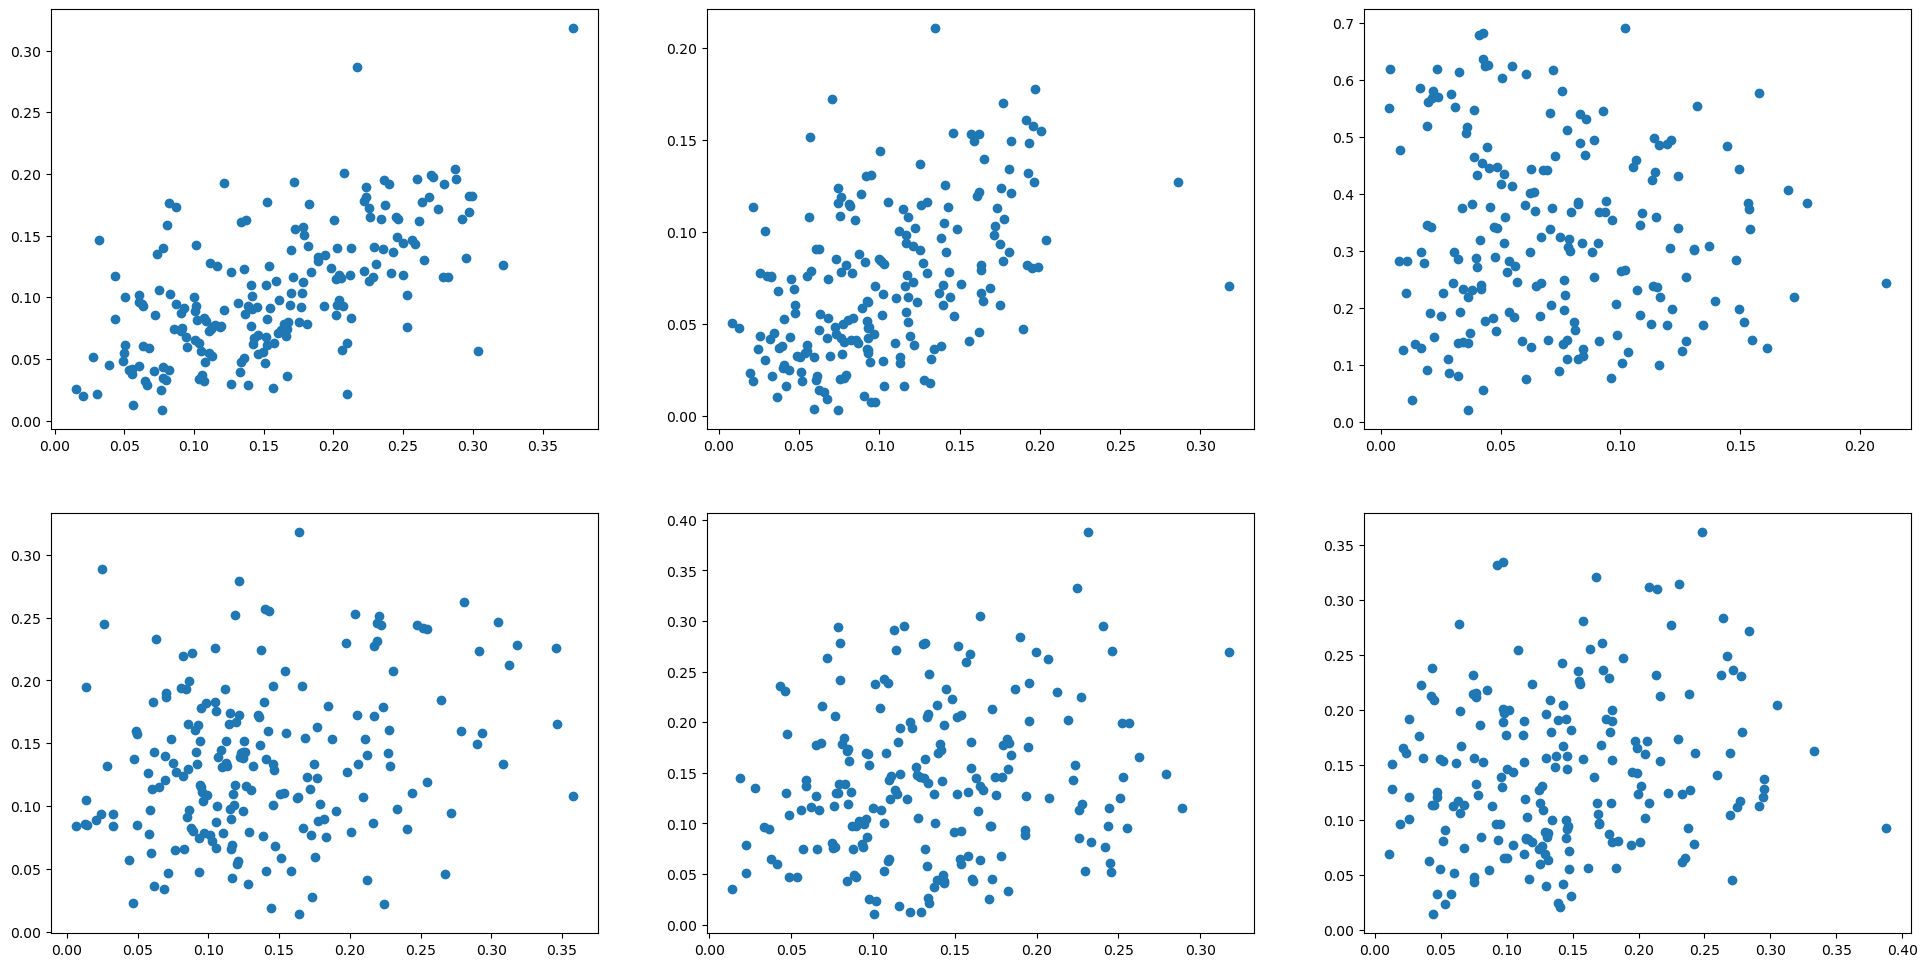

In [7]:
# plt.matshow(np.log10(welch_coherence_mat[0,:,:]))
# plt.matshow(np.abs(norm_win_spectra[0,:,:]))
f_index = 30
shift = 1

plt.figure(figsize=(24,12))
plt.subplot(2,3,1)
plt.plot(np.abs(norm_win_spectra[f_index,:,3])*shift, np.abs(norm_win_spectra[f_index,:,4])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,2)
plt.plot(np.abs(norm_win_spectra[f_index,:,4])*shift, np.abs(norm_win_spectra[f_index,:,5])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,3)
plt.plot(np.abs(norm_win_spectra[f_index,:,5])*shift, np.abs(norm_win_spectra[f_index,:,6])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

f_index = 400
plt.subplot(2,3,4)
plt.plot(np.abs(norm_win_spectra[f_index,:,3])*shift, np.abs(norm_win_spectra[f_index,:,4])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,5)
plt.plot(np.abs(norm_win_spectra[f_index,:,4])*shift, np.abs(norm_win_spectra[f_index,:,5])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,6)
plt.plot(np.abs(norm_win_spectra[f_index,:,5])*shift, np.abs(norm_win_spectra[f_index,:,6])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

In [8]:
(np.abs(norm_win_spectra[f_index,:,(3,4,5)])*shift).T.shape

(200, 3)

In [9]:
f_index = 30
shift = 1

# Create a list of vectors
vectors = [
    np.array([1, 2, 3]),
    np.array([4, 5, 6]),
    np.array([7, 8, 9]),
    # Add more vectors as needed
]

points = np.abs(norm_win_spectra[f_index,:,(4,5,6)])*shift
vectors = points.T

# Extract coordinates from vectors
x_coords = [vector[0] for vector in vectors]
y_coords = [vector[1] for vector in vectors]
z_coords = [vector[2] for vector in vectors]

# Create a 3D scatter plot
fig = go.Figure()

# Add scatter points for each vector
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers'))

# Set layout properties
fig.update_layout(scene=dict(aspectmode="cube", xaxis=dict(title="X"), yaxis=dict(title="Y"), zaxis=dict(title="Z")),
                  margin=dict(l=0, r=0, b=0, t=0))



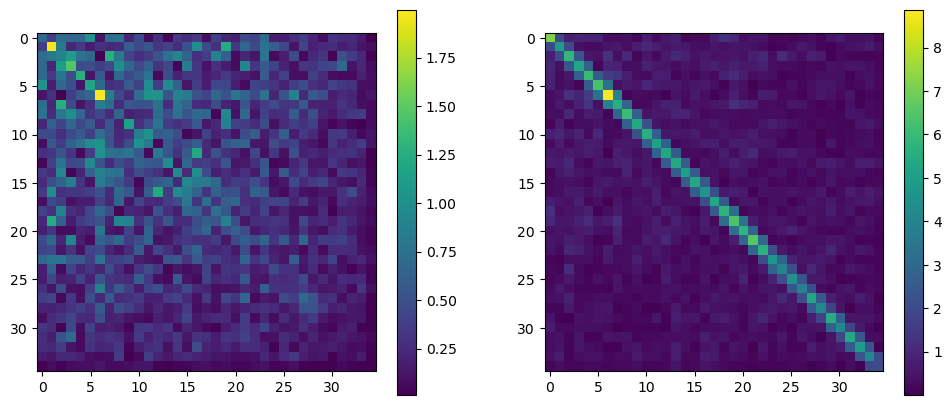

In [18]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
Q1,R1 = np.linalg.qr(RandA.T)
# plt.matshow(np.abs(R1@R1.T))
plt.imshow(np.abs(R1@R1.T))
plt.colorbar()
plt.subplot(1,2,2)
Q1,R1 = np.linalg.qr(RandA)
plt.imshow(np.abs(R1@R1.T))
plt.colorbar()
# plt.subplot(1,3,3)



In [19]:
norm_win_spectra.shape

(2501, 200, 35)

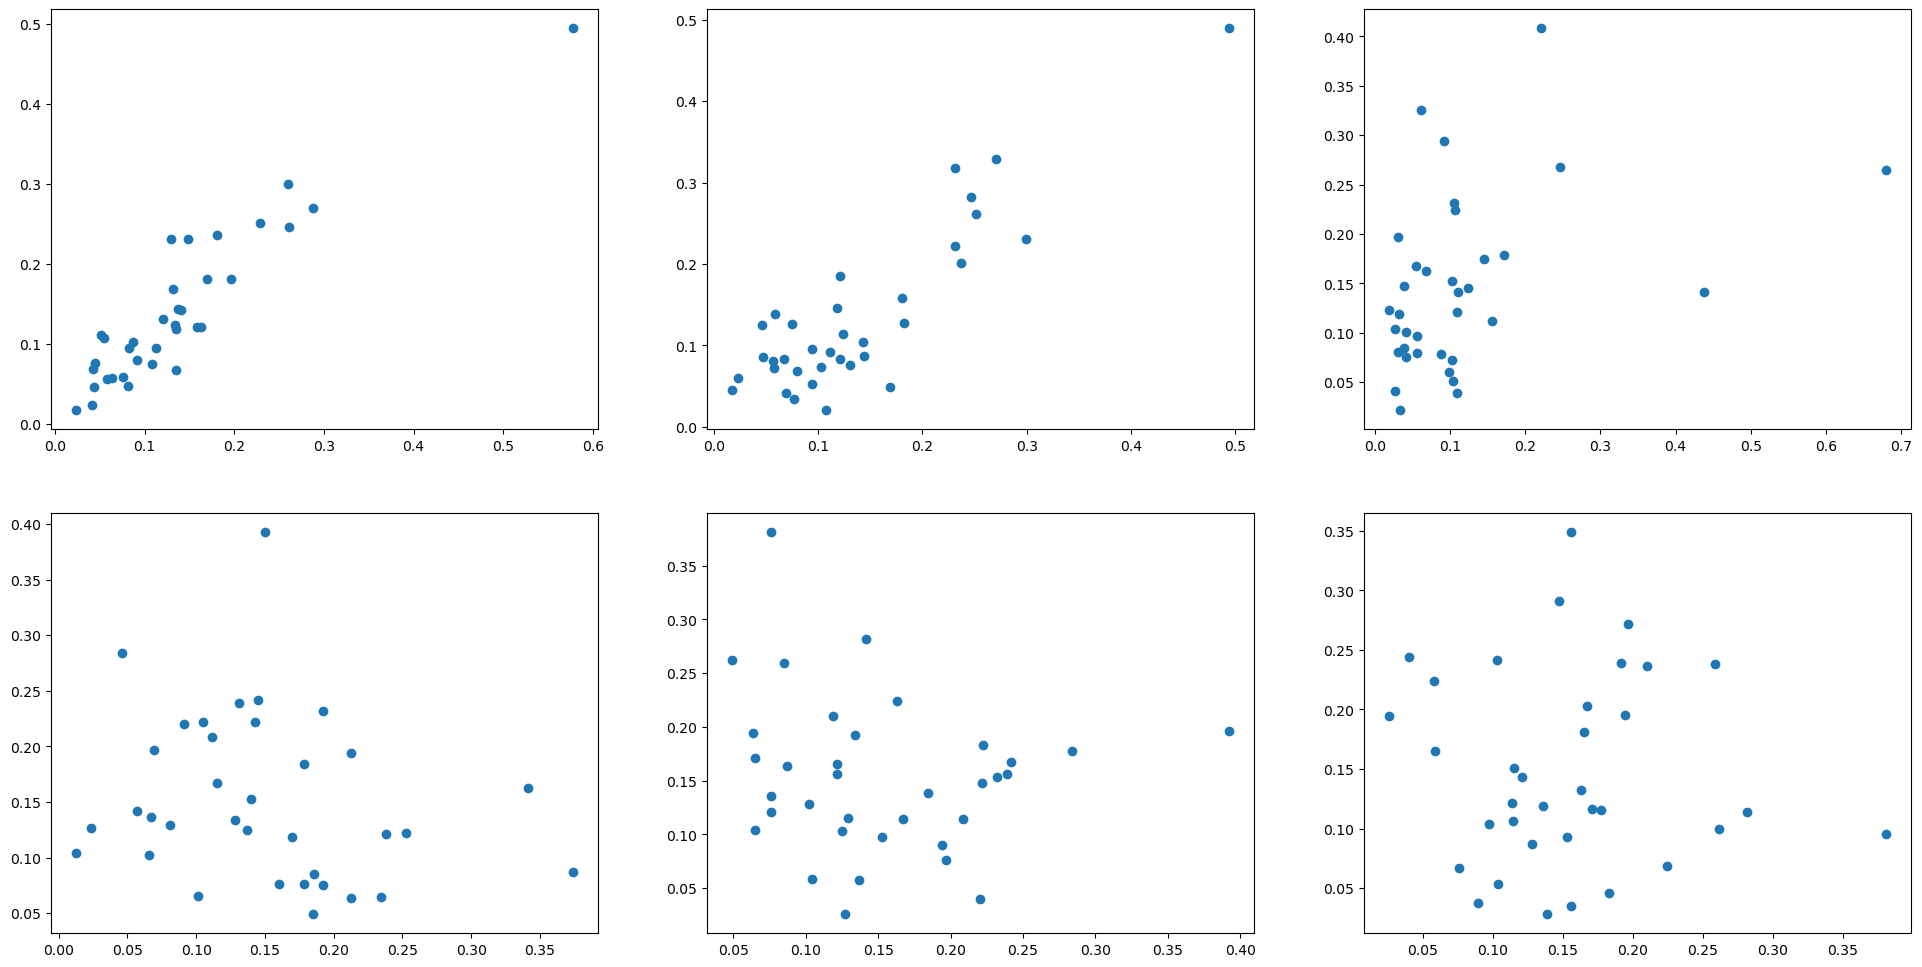

In [11]:
# plt.matshow(np.log10(welch_coherence_mat[0,:,:]))
# plt.matshow(np.abs(norm_win_spectra[0,:,:]))
f_index = 30
shift = 1

plt.figure(figsize=(24,12))
plt.subplot(2,3,1)
plt.plot(np.abs(norm_win_spectra[f_index,3,:])*shift, np.abs(norm_win_spectra[f_index,4,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,2)
plt.plot(np.abs(norm_win_spectra[f_index,4,:])*shift, np.abs(norm_win_spectra[f_index,5,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,3)
plt.plot(np.abs(norm_win_spectra[f_index,10,:])*shift, np.abs(norm_win_spectra[f_index,12,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

f_index = 400
plt.subplot(2,3,4)
plt.plot(np.abs(norm_win_spectra[f_index,3,:])*shift, np.abs(norm_win_spectra[f_index,4,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,5)
plt.plot(np.abs(norm_win_spectra[f_index,4,:])*shift, np.abs(norm_win_spectra[f_index,5,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)
plt.subplot(2,3,6)
plt.plot(np.abs(norm_win_spectra[f_index,5,:])*shift, np.abs(norm_win_spectra[f_index,6,:])*shift, 'o')
# plt.plot(np.abs(norm_win_spectra[f_index,:,3]), np.abs(norm_win_spectra[f_index,:,4]), 'o')
# plt.xlim(0,shift+0.4)
# plt.ylim(0,shift+0.4)

In [12]:
f_index = 30
shift = 1

# Create a list of vectors
vectors = [
    np.array([1, 2, 3]),
    np.array([4, 5, 6]),
    np.array([7, 8, 9]),
    # Add more vectors as needed
]

points = np.abs(norm_win_spectra[f_index,(4,5,6),:])*shift
vectors = points.T

# Extract coordinates from vectors
x_coords = [vector[0] for vector in vectors]
y_coords = [vector[1] for vector in vectors]
z_coords = [vector[2] for vector in vectors]

# Create a 3D scatter plot
fig = go.Figure()

# Add scatter points for each vector
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers'))

# Set layout properties
fig.update_layout(scene=dict(aspectmode="cube", xaxis=dict(title="X"), yaxis=dict(title="Y"), zaxis=dict(title="Z")),
                  margin=dict(l=0, r=0, b=0, t=0))

C:\Users\issah\AppData\Local\Temp\ipykernel_26356\3004573300.py:4: ComplexWarning:

Casting complex values to real discards the imaginary part



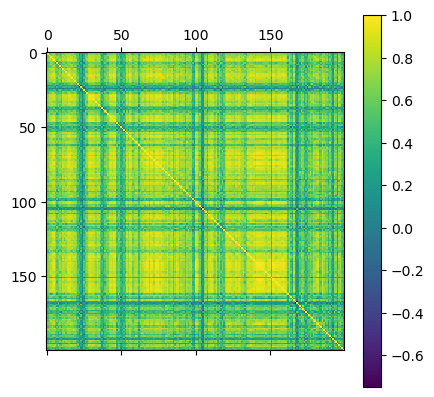

In [13]:
# np.sum(np.abs(norm_win_spectra[f_index,:,:]), axis=0)
# np.sum(np.abs(welch_coherence_mat[0,:,:]), axis=0)
# np.abs(norm_win_spectra[f_index,:,:]).shape
plt.matshow(welch_coherence_mat[0,:,:].astype(np.float64))
plt.colorbar()

In [14]:
fsize = 15
# num_frames = coherence2.shape[0]
# data_2use = welch_coherence_mat.real
data_2use = np.absolute(welch_coherence_mat)**2
num_frames = int(data_2use.shape[0]/2)

eig_ratios2 = np.empty(num_frames)
eig_ratios_qr = np.empty(num_frames)
eig_ratios_qr2 = np.empty(num_frames)
eig_ratios_qr_diag = np.empty(num_frames)
eig_ratios_qr2_diag = np.empty(num_frames)
eig_ratios_svd = np.empty(num_frames)
eig_ratios_rsvd = np.empty(num_frames)
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(data_2use[d*2])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)

    Q,R = np.linalg.qr(norm_win_spectra[d*2])
    qr_approx = np.sort(np.sum(np.absolute(R@R.transpose()), axis=0))[::-1]
    qr_approx_diag = np.sort(np.diag(np.absolute(R@R.transpose())))[::-1]
    # qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
    eig_ratios_qr[d] = qr_approx[0]/np.sum(np.absolute(qr_approx))
    eig_ratios_qr_diag[d] = qr_approx_diag[0]/np.sum(np.absolute(qr_approx_diag))

    Q,R = np.linalg.qr(norm_win_spectra[d*2].T)
    qr_approx2_diag = np.sort(np.diag(np.absolute(R@R.transpose())))[::-1]
    qr_approx2 = np.sort(np.sum(np.absolute(R@R.transpose()), axis=0))[::-1]
    # qr_approx = np.sort(np.sum(R@R.transpose(), axis=0))[::-1]
    eig_ratios_qr2[d] = qr_approx2[0]/np.sum(np.absolute(qr_approx2))
    eig_ratios_qr2_diag[d] = qr_approx2_diag[0]/np.sum(np.absolute(qr_approx2_diag))

    # U, S, Vh = np.linalg.svd(norm_win_spectra[d*2])
    # svd_approx = S**2
    # eig_ratios_svd[d] = svd_approx[0]/np.sum(svd_approx)

    # rU, rS, rVh = randomized_svd(norm_win_spectra[d*2], approx_rank) 
    # rsvd_approx = rS**2
    # eig_ratios_rsvd[d] = rsvd_approx[0]/np.sum(rsvd_approx)
    

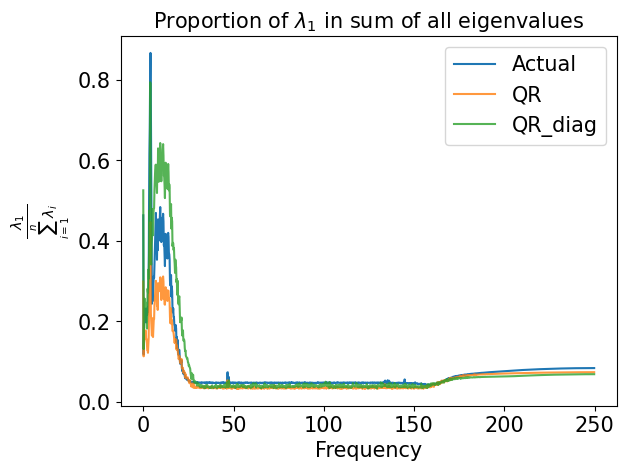

In [17]:
plt.plot(frequencies[:num_frames], eig_ratios2, label="Actual")
plt.plot(frequencies[:num_frames], eig_ratios_qr, label="QR",alpha=0.8)
# plt.plot(frequencies[:num_frames], eig_ratios_qr2, label="QR2",alpha=0.6)
plt.plot(frequencies[:num_frames], eig_ratios_qr_diag, label="QR_diag",alpha=0.8)
# plt.plot(frequencies[:num_frames], eig_ratios_qr2_diag, label="QR2_diag",alpha=0.6)
# plt.plot(frequencies[:num_frames], eig_ratios_svd, label="SVD",alpha=0.4)
# plt.plot(frequencies[:num_frames], eig_ratios_rsvd, label="rSVD",alpha=0.2)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize)